In [39]:
import numpy as np
import cv2
from scipy.linalg import svd
from scipy.fftpack import dct
from sklearn.decomposition import PCA
import pywt

In [2]:
import matplotlib.pyplot as plt

def plot_frame(frame, title):
    plt.figure()
    plt.imshow(frame, cmap='gray')
    plt.title(title)
    # remove ticks
    plt.xticks([])
    plt.yticks([])
    plt.show()

(102240, 120)


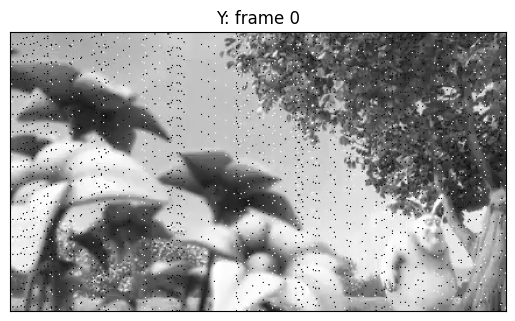

In [3]:
vid = cv2.VideoCapture('in/video_noisy.mp4')
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if ret:
        # Convert to grayscale and flatten
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(frame_gray.flatten())
    else:
        break
vid.release()
frames = np.array(frames)
Y = frames.T
print(Y.shape)
plot_frame(Y[:, 0].reshape(240, 426), 'Y: frame 0')

In [4]:
'''X = np.zeros(Y.shape)
for i in range(Y.shape[1]):
    X[:, i] = cv2.medianBlur(Y[:, i].reshape(240, 426).astype(np.uint8), 3).flatten()   
print(X.shape)
plot_frame(X[:, 0].reshape(240, 426), 'X: frame 0')'''

"X = np.zeros(Y.shape)\nfor i in range(Y.shape[1]):\n    X[:, i] = cv2.medianBlur(Y[:, i].reshape(240, 426).astype(np.uint8), 3).flatten()   \nprint(X.shape)\nplot_frame(X[:, 0].reshape(240, 426), 'X: frame 0')"

In [15]:
def create_dct_basis(n, c):
    return dct(np.eye(n, c), norm='ortho', axis=0)

In [83]:
slice_size = 50 # quanto vamos pegar de cada base?

dct_basis = create_dct_basis(Y.shape[0], slice_size)

pca = PCA(n_components=slice_size)
pca_basis = pca.fit(Y.T).components_.T

In [85]:
def is_orthonormal(matrix, tol=1e-9):
    """
    Check if the columns of a matrix form an orthonormal basis.

    Parameters:
    - matrix (np.ndarray): The matrix to check (shape: m x n).
    - tol (float): Tolerance for numerical comparisons.

    Returns:
    - bool: True if the columns are orthonormal, False otherwise.
    """
    # Compute A.T @ A
    gram_matrix = matrix.T @ matrix
    # Check if the Gram matrix is close to the identity matrix
    identity = np.eye(gram_matrix.shape[0])
    return np.allclose(gram_matrix, identity, atol=tol)

In [87]:
is_orthonormal(dct_basis), is_orthonormal(pca_basis)

(True, True)

In [84]:
X = np.hstack([dct_basis, pca_basis])
X.shape

(102240, 100)

In [75]:
B_ols = np.linalg.lstsq(X, Y, rcond=None)[0]
B_ols.shape

(100, 120)

In [76]:
r = 10

In [77]:
U, s, Vt = np.linalg.svd(X @ B_ols, full_matrices=False)
# truncando
Vr = Vt[:r, :].T
Ur = U[:, :r]
print(Vt.shape)

(120, 120)


In [78]:
B_rrr = B_ols @ Vr @ Vr.T
B_rrr.shape

(100, 120)

In [79]:
Yr = X @ B_rrr

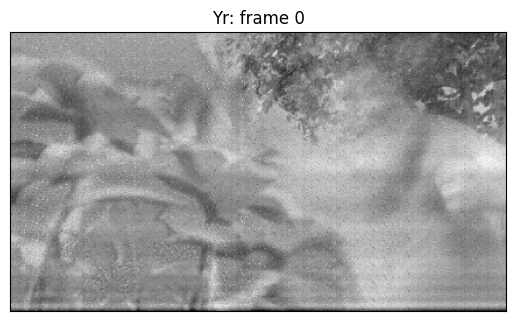

In [80]:
plot_frame(Yr[:, 60].reshape(240, 426), 'Yr: frame 0')

In [81]:
Y_out = Yr.T.reshape(-1, 240, 426)
frames_normalized = []
for i, frame in enumerate(Y_out):
    frame_normalized = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    frames_normalized.append(frame_normalized)
# write video
out = cv2.VideoWriter('out/video_reconstructed_final_v2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (426, 240))
for frame in frames_normalized:
    out.write(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))
out.release()

O resultado final é estranho! Parece "priorizar" as plantas e os céus. Isso faz algum sentido, visto que compoem a maior parte do vídeo original.

Vamos tentar usar mais alguns autovetores. Para saber um número mais ideal, vamos analisar os valores singulares.

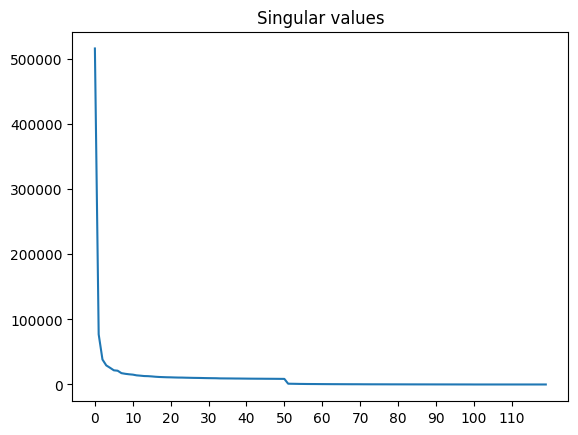

In [82]:
# plot s
plt.plot(s)
plt.title('Singular values')
# add more ticks
plt.xticks(range(0, len(s), 10))
plt.show()